In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


**Задание 1 (0.5 балла) Подготовка**


Разделите выборку на train, val, test (80%, 10%, 10%)
Выдерите salary_in_usd в качестве таргета
Найдите и удалите признак, из-за которого возможен лик в данных

In [ ]:
from sklearn.model_selection import train_test_split


df = df.drop(columns=['salary', 'salary_currency'])

train_val, test = train_test_split(df, test_size=0.1, random_state=52)
train, val = train_test_split(train_val, test_size=0.1, random_state=52)

X_train = train.drop(columns=['salary_in_usd'])
y_train = train['salary_in_usd']
X_val = val.drop(columns=['salary_in_usd'])
y_val = val['salary_in_usd']
X_test = test.drop(columns=['salary_in_usd'])
y_test = test['salary_in_usd']

print(X_train.head())
print(y_train.head())

      work_year experience_level employment_type              job_title  \
1839       2022               SE              FT          Data Engineer   
1318       2023               SE              FT         Data Scientist   
1406       2023               MI              FT           Data Analyst   
1527       2022               EN              FT  Business Data Analyst   
126        2023               SE              FT          Data Engineer   

     employee_residence  remote_ratio company_location company_size  
1839                 US             0               US            M  
1318                 US             0               US            M  
1406                 US             0               US            M  
1527                 US            50               US            L  
126                  US             0               US            M  
1839    115000
1318    140800
1406    150000
1527     48000
126     129300
Name: salary_in_usd, dtype: int64


**Задание 2 (0.5 балла) Линейная модель**


Закодируйте категориальные признаки с помощью OneHotEncoder
Обучите модель линейной регрессии
Оцените качество через MAPE и RMSE

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from math import sqrt


categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train[categorical_features])

X_train_encoded = encoder.transform(train[categorical_features])
X_val_encoded = encoder.transform(val[categorical_features])

X_train_full = pd.concat([pd.DataFrame(X_train_encoded, index=train.index), train.drop(columns=categorical_features + ['salary_in_usd'])], axis=1)
X_val_full = pd.concat([pd.DataFrame(X_val_encoded, index=val.index), val.drop(columns=categorical_features + ['salary_in_usd'])], axis=1)

X_train_full.columns = X_train_full.columns.astype(str)
X_val_full.columns = X_val_full.columns.astype(str)

y_train = train['salary_in_usd']
y_val = val['salary_in_usd']

model = LinearRegression()
model.fit(X_train_full, y_train)

y_pred = model.predict(X_val_full)

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = sqrt(mean_squared_error(y_val, y_pred))

print('MAPE:', mape)
print('RMSE:', rmse)


MAPE: 29796843.35545872
RMSE: 19096894925219.414


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Задание 3 (0.5 балла) XGboost**

Начнем с библиотеки xgboost.

Обучите модель XGBRegressor на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (max_depth, learning_rate, n_estimators, gamma, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt
import time


param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

start_time = time.time()
grid_search.fit(X_train_full, y_train)
training_time = time.time() - start_time

best_model = grid_search.best_estimator_

start_time = time.time()
y_pred = best_model.predict(X_val_full)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = sqrt(mean_squared_error(y_val, y_pred))

print('Лучшие параметры:', grid_search.best_params_)
print('MAPE:', mape)
print('RMSE:', rmse)
print('Training time (seconds):', training_time)
print('Prediction time (seconds):', prediction_time)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estim

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

model = CatBoostRegressor(loss_function='RMSE', verbose=False)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

start_time = time.time()
grid_search.fit(X_train_full, y_train)
training_time = time.time() - start_time

best_model = grid_search.best_estimator_

start_time = time.time()
y_pred = best_model.predict(X_val_full)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = sqrt(mean_squared_error(y_val, y_pred))

print('Лучшие параметры:', grid_search.best_params_)
print('MAPE:', mape)
print('RMSE:', rmse)
print('Training time (seconds):', training_time)
print('Prediction time (seconds):', prediction_time)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.3s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=   0.1s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.1s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.1s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.1s
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=   0.2s
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=   0.2s
[CV] END ........depth=4, iterations=200, learni

In [ ]:
from catboost import Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

model = CatBoostRegressor(loss_function='RMSE', verbose=False)

start_time = time.time()
model.grid_search(param_grid, train_pool, cv=3, partition_random_seed=42, search_by_train_test_split=True, refit=True)
training_time = time.time() - start_time

start_time = time.time()
y_pred = model.predict(X_val)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = sqrt(mean_squared_error(y_val, y_pred))

print('Лучшие параметры:', model.get_params())
print('MAPE:', mape)
print('RMSE:', rmse)
print('Training time (seconds):', training_time)
print('Prediction time (seconds):', prediction_time)


bestTest = 76413.74788
bestIteration = 99

0:	loss: 76413.7478784	best: 76413.7478784 (0)	total: 158ms	remaining: 4.1s

bestTest = 49475.26285
bestIteration = 99

1:	loss: 49475.2628488	best: 49475.2628488 (1)	total: 354ms	remaining: 4.43s

bestTest = 49039.38651
bestIteration = 86

2:	loss: 49039.3865131	best: 49039.3865131 (2)	total: 532ms	remaining: 4.26s

bestTest = 55508.11918
bestIteration = 199

3:	loss: 55508.1191842	best: 49039.3865131 (2)	total: 1.02s	remaining: 5.88s

bestTest = 48692.48688
bestIteration = 199

4:	loss: 48692.4868808	best: 48692.4868808 (4)	total: 1.58s	remaining: 6.97s

bestTest = 48340.68119
bestIteration = 199

5:	loss: 48340.6811908	best: 48340.6811908 (5)	total: 2.16s	remaining: 7.56s

bestTest = 50946.56313
bestIteration = 299

6:	loss: 50946.5631269	best: 48340.6811908 (5)	total: 3.13s	remaining: 8.95s

bestTest = 48501.72916
bestIteration = 298

7:	loss: 48501.7291572	best: 48340.6811908 (5)	total: 4.24s	remaining: 10.1s

bestTest = 48118.90525
best

Общее время обучения увеличилось, ошибки тоже. Но незначительно ускорилось время предсказания. Итог - с таким подходом все чуть хуже.

**Задание 5 (0.5 балла) LightGBM**


И наконец библиотека LightGBM - используйте LGBMRegressor, снова подберите гиперпараметры, оцените качество и скорость.

In [ ]:
from lightgbm import LGBMRegressor

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 70]
}

model = LGBMRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

start_time = time.time()
grid_search.fit(X_train_full, y_train)
training_time = time.time() - start_time

best_model = grid_search.best_estimator_

start_time = time.time()
y_pred = best_model.predict(X_val_full)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = sqrt(mean_squared_error(y_val, y_pred))

print('Лучшие параметры:', grid_search.best_params_)
print('MAPE:', mape)
print('RMSE:', rmse)
print('Training time (seconds):', training_time)
print('Prediction time (seconds):', prediction_time)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 2002, number of used features: 35
[LightGBM] [Info] Start training from score 137164.027972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

**Задание 6 (2 балла) Сравнение и выводы**

Все рассмотренные модели кластеризации показали хороший, почти одинаковый MAPE (около 0.3-0.4), также получился очень схожий RMSE. Лучшим по точности в итоге оказался CatBoost без использования Pool, но он обучается немного дольше остальных моделей. LightGBM и XGBRegressor примерны одинаковы по качеству и времени.

Нужна точность - CatBoost (без Pool)

Нужна хорошая скорость обучения - XGBRegressor/LightGBM

Нужно быстро давать прогноз - CatBoost (с Pool)


**Часть 2 Кластеризация (5 баллов)**

In [2]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Задание 1 (0.5 балла) Подготовка**


Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [3]:
ratings = ratings.transpose()

ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием user.

In [4]:
ratings = ratings.drop('user')
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)

Доля исполнителя в музыке, прослушанной пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.

In [5]:
ratings= ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
t.i.,0.015593,0.0,0.0,0.0,0.0,0.0,0.0,0.012217,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Задание 2 (0.5 балла) Первая кластеризация**

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [7]:
from sklearn.cluster import KMeans

ratings.columns = ratings.columns.astype(str)
kmeans = KMeans(n_clusters=5, random_state=52)
kmeans.fit(ratings)
labels = kmeans.labels_

ratings['Cluster'] = labels
print(ratings.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                           0         1         2    3         4         5  \
the beatles         0.000000  0.000000  0.000000  0.0  0.043529  0.000000   
radiohead           0.020417  0.184962  0.000000  0.0  0.086281  0.006322   
deathcab for cutie  0.000000  0.024561  0.028635  0.0  0.034590  0.000000   
coldplay            0.000000  0.000000  0.000000  0.0  0.016712  0.000000   
modest mouse        0.000000  0.000000  0.000000  0.0  0.015935  0.000000   

                      6    7         8         9  ...  4991      4992  \
the beatles         0.0  0.0  0.093398  0.017621  ...   0.0  0.121169   
radiohead           0.0  0.0  0.000000  0.019156  ...   0.0  0.000000   
deathcab for cutie  0.0  0.0  0.000000  0.013349  ...   0.0  0.000000   
coldplay            0.0  0.0  0.000000  0.000000  ...   0.0  0.000000   
modest mouse        0.0  0.0  0.000000  0.030437  ...   0.0  0.000000   

                        4993      4994      4995  4996      4997  4998  \
the beatles         0.03

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [8]:
cluster_sizes = ratings['Cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes)

Размеры кластеров:
Cluster
1    991
0      6
2      1
4      1
3      1
Name: count, dtype: int64


Кластеризация получилась не очень полезной, тк KMeans большинство определил в первый кластер, а остальные оставил почти пустыми. Такое могло возникнуть из-за несбалансированных данных, к тому же много мы заполнили нулями, что тоже негативно влияет на работу данной модели. Также возможно данные имеют сильно похожие значения, что тоже ломает нашу модель.

**Задание 3 (0.5 балла) Объяснение результатов**



In [9]:
micro_clusters = cluster_sizes[cluster_sizes == 1].index
artists_in_micro_clusters = ratings[ratings['Cluster'].isin(micro_clusters)].index.tolist()

artists_in_micro_clusters

['the beatles', 'queen', 'the misfits']

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [10]:
user_count = ratings.shape[1]
listening_share = (ratings > 0).sum(axis=1) / user_count

average_listening_share = ratings.mean(axis=1)

artist_stats = pd.DataFrame({
    'Доля пользователей, которые слушают': listening_share,
    'Средняя доля прослушивания': average_listening_share
})

print(artist_stats)
print("\nСтатистика для 'The Beatles':")
print(artist_stats.loc['the beatles'])

                    Доля пользователей, которые слушают  \
the beatles                                    0.334333   
radiohead                                      0.277744   
deathcab for cutie                             0.186363   
coldplay                                       0.168366   
modest mouse                                   0.162967   
...                                                 ...   
michal w. smith                                0.009598   
群星                                             0.009598   
agalloch                                       0.009598   
meshuggah                                      0.009598   
yellowcard                                     0.009598   

                    Средняя доля прослушивания  
the beatles                           0.018765  
radiohead                             0.011849  
deathcab for cutie                    0.006742  
coldplay                              0.006229  
modest mouse                          0.006075

Как видим the beatles сильно выделяется среди остальных, их слушает огромная доля людей - 0.334, что выделяет данную группу среди остальных.

**Задание 4 (0.5 балла)**

Улучшение кластеризации
Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи normalize.

In [11]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, axis=1)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [12]:
kmeans = KMeans(n_clusters=5, random_state=52)
kmeans.fit(ratings_normalized)

labels = kmeans.labels_

ratings['Cluster'] = labels

cluster_sizes = ratings['Cluster'].value_counts()

print("Размеры кластеров после нормализации:")
print(cluster_sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Размеры кластеров после нормализации:
Cluster
1    692
3    261
0     40
2      5
4      2
Name: count, dtype: int64


Стало значительно лучше, появилось 3 различмых кластера. Теперь модель может быть полезна.

**Задание 5 (1 балл) Центроиды**

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [13]:
from scipy.spatial.distance import cosine

centroids = kmeans.cluster_centers_

def top_10_nearest_artists_to_centroid(cluster_id, ratings_normalized, centroids, ratings):
    distances = {}
    centroid = centroids[cluster_id]
    for artist in ratings[ratings['Cluster'] == cluster_id].index:
        artist_vector = ratings_normalized[ratings.index.get_loc(artist)]
        distance = cosine(artist_vector, centroid)
        distances[artist] = distance
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    return [artist for artist, _ in sorted_distances[:10]]

for cluster_id in range(5):
    print(f"\nТоп-10 исполнителей для кластера {cluster_id}:")
    top_10_artists = top_10_nearest_artists_to_centroid(cluster_id, ratings_normalized, centroids, ratings)
    for artist in top_10_artists:
        print(artist)


Топ-10 исполнителей для кластера 0:
the cure
u2
dead can dance
depeche Мode
sufjan stevens
björk guğmunsdóttir
animal collective
bonobo
they might be giants [tmbg]
the beach boys

Топ-10 исполнителей для кластера 1:
the quitters
jet
dangerdoom
jenny lewis with the watson twins
hawthorne heights
conor oberst
kasabian
eve 6
plus-44
murs and 9th wonder

Топ-10 исполнителей для кластера 2:
aphex twin
stars of the lid
boards of canada
eno
radiohead

Топ-10 исполнителей для кластера 3:
the roots featuring d'angelo
neutral milk hotel
slayer
motion city soundtrack
disturbed
wilco
gogol bordello
soundgarden
spoon
the arcade fire

Топ-10 исполнителей для кластера 4:
tom waits
niИ


Распределения по кластерам представляют собой группы исполнителей, которые имеют схожие паттерны прослушивания среди пользователей.

Можно рассмотреть какой вид музыки в каждом кластере.

Кластер 0: Альтернативная, новая волна.

Кластер 1: Поп-рок, альтернативный рок.

Кластер 2: Электронная, эмбиентная и экспериментальная музыка.

Кластер 3: От хип-хопа до метала и инди-рока.

Кластер 4: Экспериментальные стили.

**Задание 6 (1 балл) Визуализация**

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики plt.scatter для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


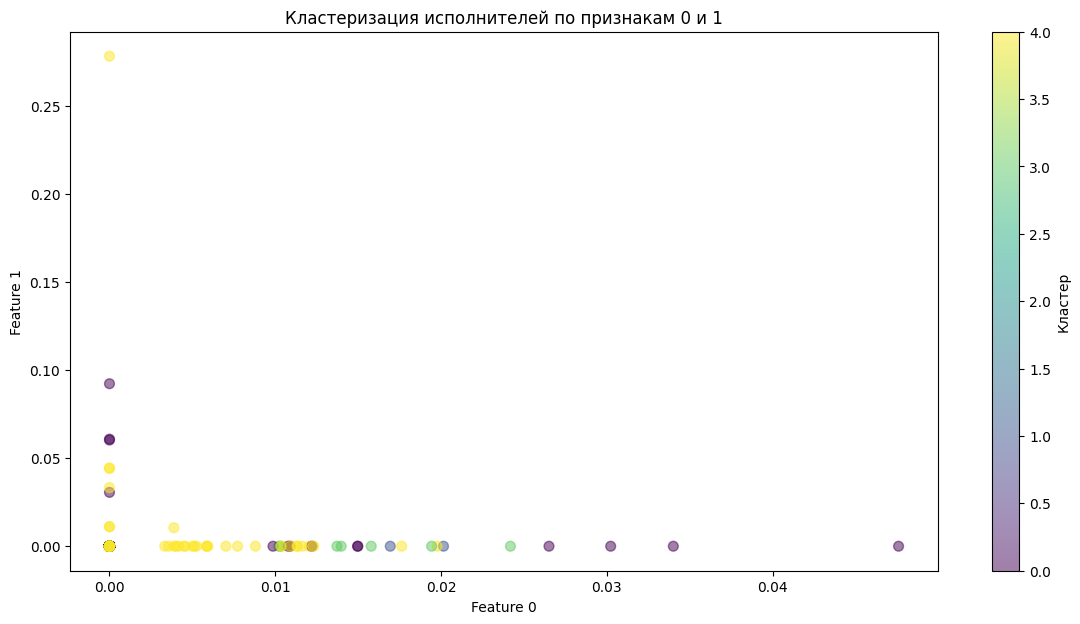

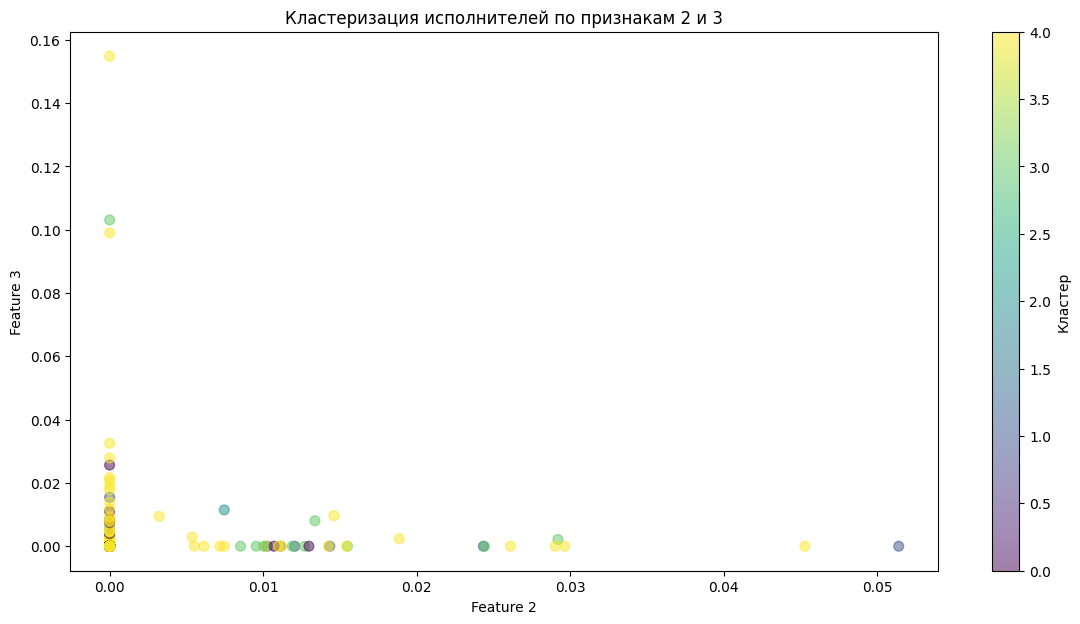

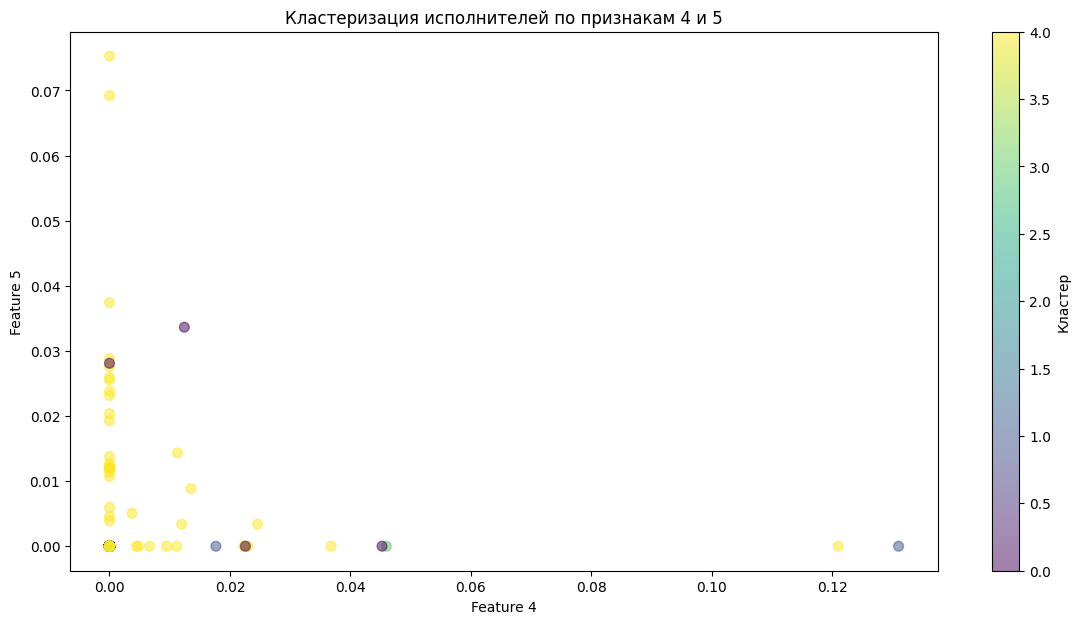

In [ ]:
import matplotlib.pyplot as plt

ratings.set_index(ratings.columns[0], inplace=True)
ratings_filled = ratings.fillna(0)
ratings_normalized = normalize(ratings_filled)

kmeans = KMeans(n_clusters=5, random_state=52)
kmeans.fit(ratings_normalized)

labels = kmeans.labels_

ratings_normalized_df = pd.DataFrame(ratings_normalized, index=ratings_filled.index)
ratings_normalized_df['Cluster'] = labels

def plot_clusters(df, feature_pairs, cluster_col='Cluster'):
    for feature_pair in feature_pairs:
        plt.figure(figsize=(14, 7))
        plt.scatter(df.iloc[:, feature_pair[0]], df.iloc[:, feature_pair[1]], c=df[cluster_col], cmap='viridis', s=50, alpha=0.5)
        plt.xlabel(f'Feature {feature_pair[0]}')
        plt.ylabel(f'Feature {feature_pair[1]}')
        plt.title(f'Кластеризация исполнителей по признакам {feature_pair[0]} и {feature_pair[1]}')
        plt.colorbar(label='Кластер')
        plt.show()

# Выбираем несколько пар признаков для визуализации (используем индексы столбцов)
feature_pairs = [
    (0, 1),
    (2, 3),
    (4, 5)
]

plot_clusters(ratings_normalized_df, feature_pairs)

Возможно, проблема в том, что визуализация двумерных данных не способна отразить все нюансы кластеризации в высокоразмерном пространстве. Данные могут быть сложными и содержать множество измерений, которые сложно интерпретировать на плоскости.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените TSNE из библиотеки sklearn и визуализируйте полученные объекты, покрасив их в цвета их кластеров

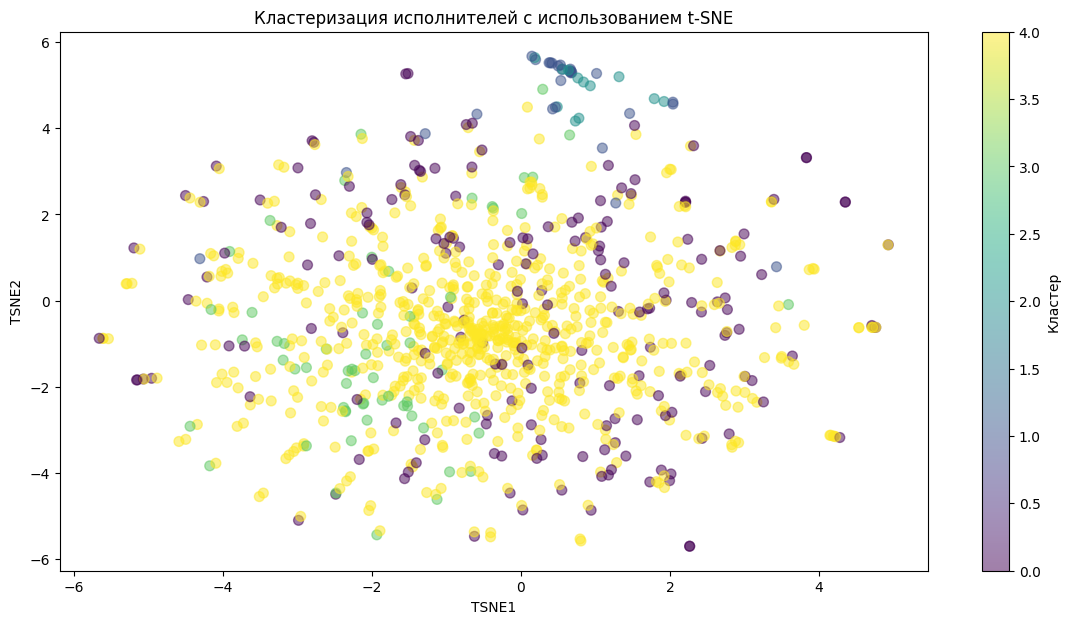

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=52)
ratings_tsne = tsne.fit_transform(ratings_normalized)

ratings_tsne_df = pd.DataFrame(ratings_tsne, index=ratings_filled.index, columns=['TSNE1', 'TSNE2'])
ratings_tsne_df['Cluster'] = labels

plt.figure(figsize=(14, 7))
plt.scatter(ratings_tsne_df['TSNE1'], ratings_tsne_df['TSNE2'], c=ratings_tsne_df['Cluster'], cmap='viridis', s=50, alpha=0.5)
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Кластеризация исполнителей с использованием t-SNE')
plt.colorbar(label='Кластер')
plt.show()

**Задание 7 (1 балл) Подбор гиперпараметров**

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте random_state=42

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 2 кластеров средний индекс силуэта: 0.5964503642826442


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 3 кластеров средний индекс силуэта: 0.5959748387347573


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 4 кластеров средний индекс силуэта: 0.5956819328788028


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 5 кластеров средний индекс силуэта: 0.5957440396665029


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 6 кластеров средний индекс силуэта: 0.04714388832311897


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 7 кластеров средний индекс силуэта: 0.14096488859202866


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 8 кластеров средний индекс силуэта: 0.13789139852883825


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 9 кластеров средний индекс силуэта: 0.14241310644457228


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 10 кластеров средний индекс силуэта: 0.5946128419959505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 11 кластеров средний индекс силуэта: 0.09982023549404016


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 12 кластеров средний индекс силуэта: 0.1329055046385643


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 13 кластеров средний индекс силуэта: -0.044469763547516465


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 14 кластеров средний индекс силуэта: 0.17363420968470686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 15 кластеров средний индекс силуэта: 0.17625821646624631


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 16 кластеров средний индекс силуэта: 0.09239314482456772


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 17 кластеров средний индекс силуэта: 0.04332688196012458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 18 кластеров средний индекс силуэта: 0.04334943096429061


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 19 кластеров средний индекс силуэта: 0.04354989372745421


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 20 кластеров средний индекс силуэта: 0.0036203421876682632


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 21 кластеров средний индекс силуэта: 0.12193632727866546


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 22 кластеров средний индекс силуэта: 0.04386204786536229


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 23 кластеров средний индекс силуэта: 0.0684188528873992


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 24 кластеров средний индекс силуэта: 0.04400594404974716


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 25 кластеров средний индекс силуэта: 0.04420974540583623


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 26 кластеров средний индекс силуэта: -0.0137263527065705


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 27 кластеров средний индекс силуэта: 0.029533058550716945


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 28 кластеров средний индекс силуэта: 0.04463604591751857


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 29 кластеров средний индекс силуэта: -0.041189042918158225


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 30 кластеров средний индекс силуэта: 0.035883682615982085


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 31 кластеров средний индекс силуэта: 0.046805120614361984


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 32 кластеров средний индекс силуэта: 0.06608957140704795


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 33 кластеров средний индекс силуэта: -0.02391282425481314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 34 кластеров средний индекс силуэта: 0.07981517153375156


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 35 кластеров средний индекс силуэта: 0.018732631072834006


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 36 кластеров средний индекс силуэта: 0.0760243584704792


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 37 кластеров средний индекс силуэта: 0.008776124302738976


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 38 кластеров средний индекс силуэта: -0.025193906001625365


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 39 кластеров средний индекс силуэта: 0.04654024213323491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 40 кластеров средний индекс силуэта: -0.0816562731465937


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 41 кластеров средний индекс силуэта: -0.010166675074922221


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 42 кластеров средний индекс силуэта: 0.03765331785087208


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 43 кластеров средний индекс силуэта: 0.04650227010694651


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 44 кластеров средний индекс силуэта: 0.04690116941165346


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 45 кластеров средний индекс силуэта: 0.052375341939367825


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 46 кластеров средний индекс силуэта: 0.11988902821243203


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 47 кластеров средний индекс силуэта: 0.07523091926124041


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 48 кластеров средний индекс силуэта: 0.009190812945212469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 49 кластеров средний индекс силуэта: -0.034766128813959504


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 50 кластеров средний индекс силуэта: 0.04049478910132589


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 51 кластеров средний индекс силуэта: -0.02136562757175266


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 52 кластеров средний индекс силуэта: 0.038605859775781626


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 53 кластеров средний индекс силуэта: 0.040076555425705616


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 54 кластеров средний индекс силуэта: 0.018087424864347987


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 55 кластеров средний индекс силуэта: -0.02684952608809592


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 56 кластеров средний индекс силуэта: 0.016883462380221394


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 57 кластеров средний индекс силуэта: 0.07514742637242526


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 58 кластеров средний индекс силуэта: 0.006640936312017205


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 59 кластеров средний индекс силуэта: -0.02993063543798111


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 60 кластеров средний индекс силуэта: 0.03961816643250333


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 61 кластеров средний индекс силуэта: 0.009426109026983698


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 62 кластеров средний индекс силуэта: 0.0716050713962955


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 63 кластеров средний индекс силуэта: -0.07074675854146742


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 64 кластеров средний индекс силуэта: 0.07764511345496666


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 65 кластеров средний индекс силуэта: 0.03514671121121842


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 66 кластеров средний индекс силуэта: 0.016385366423492975


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 67 кластеров средний индекс силуэта: 0.029064890679770257


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 68 кластеров средний индекс силуэта: 0.04057394670770647


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 69 кластеров средний индекс силуэта: 0.008654036137536967


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 70 кластеров средний индекс силуэта: -0.02471956229194226


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 71 кластеров средний индекс силуэта: 0.008797149606956985


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 72 кластеров средний индекс силуэта: 0.012701722892809122


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 73 кластеров средний индекс силуэта: 0.042140848986238905


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 74 кластеров средний индекс силуэта: -0.0015282694833783203


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 75 кластеров средний индекс силуэта: -0.027238247318458014


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 76 кластеров средний индекс силуэта: -0.12049888190586039


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 77 кластеров средний индекс силуэта: 0.06083285299370213


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 78 кластеров средний индекс силуэта: -0.036200536530535926


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 79 кластеров средний индекс силуэта: 0.014763824009817099


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 80 кластеров средний индекс силуэта: -0.03459459315246826


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 81 кластеров средний индекс силуэта: 0.006656248110800717


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 82 кластеров средний индекс силуэта: 0.018346053677399513


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 83 кластеров средний индекс силуэта: -0.06263032947355668


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 84 кластеров средний индекс силуэта: 0.07805554925268382


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 85 кластеров средний индекс силуэта: -0.025863693294097084


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 86 кластеров средний индекс силуэта: -0.0891234726972757


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 87 кластеров средний индекс силуэта: -0.057401156710479066


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 88 кластеров средний индекс силуэта: 0.05960284281854196


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 89 кластеров средний индекс силуэта: -0.10336913191559685


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 90 кластеров средний индекс силуэта: 0.03797930224208759


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 91 кластеров средний индекс силуэта: 0.022938809395529277


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 92 кластеров средний индекс силуэта: 0.0038630356042788742


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 93 кластеров средний индекс силуэта: -0.06578728508223537


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 94 кластеров средний индекс силуэта: 0.06632521271644315


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 95 кластеров средний индекс силуэта: 0.04344965997628216


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 96 кластеров средний индекс силуэта: -0.0843732254028549


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 97 кластеров средний индекс силуэта: 0.029723658081341378


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 98 кластеров средний индекс силуэта: 0.03554799878252963


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 99 кластеров средний индекс силуэта: 0.032771278355155906


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для 100 кластеров средний индекс силуэта: 0.0100889453846278

Оптимальное количество кластеров: 2


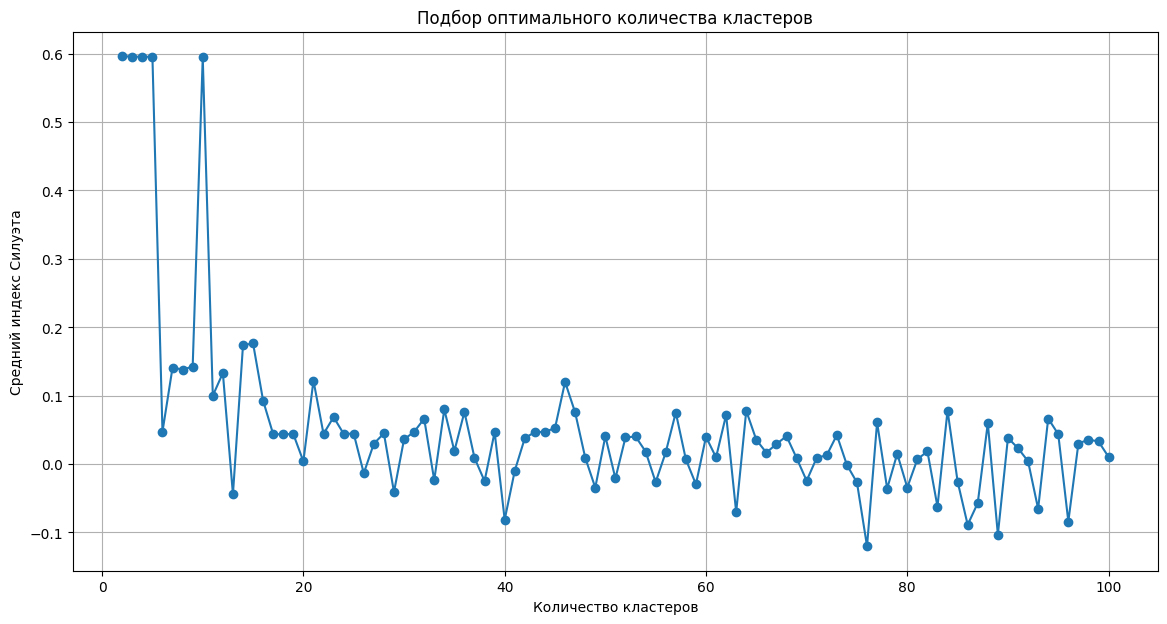

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2, 101))
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(ratings_normalized)
    silhouette_avg = silhouette_score(ratings_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Для {n_clusters} кластеров средний индекс силуэта: {silhouette_avg}")

optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nОптимальное количество кластеров: {optimal_n_clusters}")

plt.figure(figsize=(14, 7))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний индекс Силуэта')
plt.title('Подбор оптимального количества кластеров')
plt.grid(True)
plt.show()

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(ratings_normalized)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

ratings['Cluster'] = labels

for cluster_id in range(2):
    print(f"\nТоп-10 исполнителей для кластера {cluster_id}:")
    top_10_artists = top_10_nearest_artists_to_centroid(cluster_id, ratings_normalized, centroids, ratings)
    for artist in top_10_artists:
        print(artist)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Топ-10 исполнителей для кластера 0:
the arcade fire
spoon
the shins
cake
white stripes
the national
foo fighters
r.e.m.
sonic youth
perfect circle

Топ-10 исполнителей для кластера 1:
the quitters
jet
dangerdoom
jenny lewis with the watson twins
hawthorne heights
conor oberst
kasabian
eve 6
plus-44
murs and 9th wonder


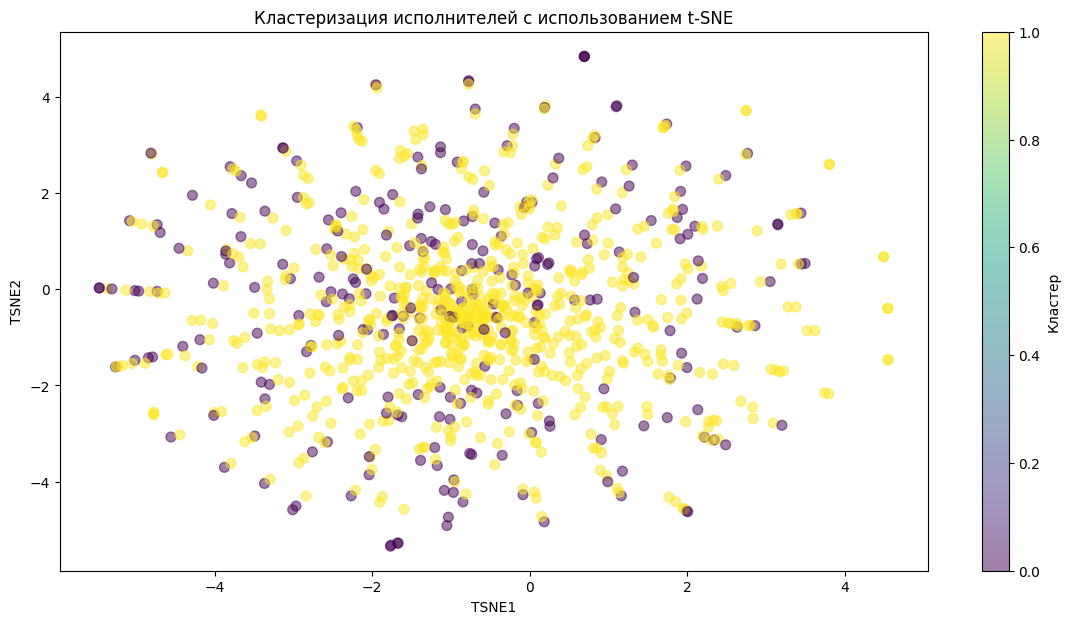

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(ratings_normalized)

ratings_tsne_df = pd.DataFrame(ratings_tsne, index=ratings.index, columns=['TSNE1', 'TSNE2'])
ratings_tsne_df['Cluster'] = labels

plt.figure(figsize=(14, 7))
plt.scatter(ratings_tsne_df['TSNE1'], ratings_tsne_df['TSNE2'], c=ratings_tsne_df['Cluster'], cmap='viridis', s=50, alpha=0.5)
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Кластеризация исполнителей с использованием t-SNE')
plt.colorbar(label='Кластер')
plt.show()

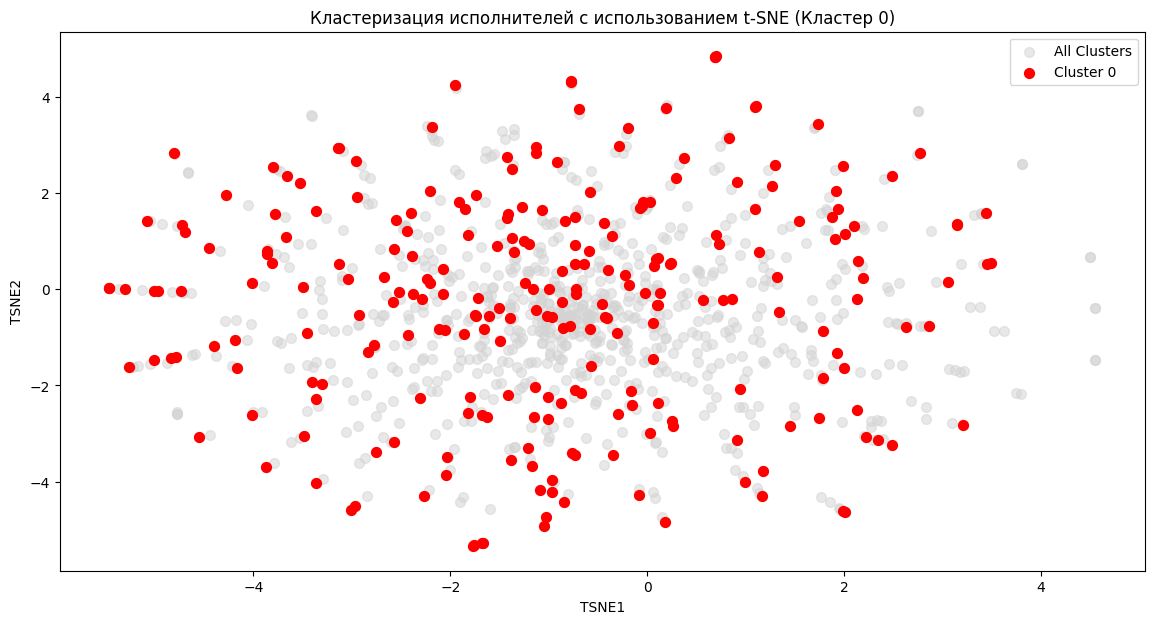

In [22]:
plt.figure(figsize=(14, 7))
plt.scatter(ratings_tsne_df['TSNE1'], ratings_tsne_df['TSNE2'], c='lightgray', s=50, alpha=0.5, label='All Clusters')
interesting_cluster_id = 0
cluster_data = ratings_tsne_df[ratings_tsne_df['Cluster'] == interesting_cluster_id]
plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], c='red', s=50, label=f'Cluster {interesting_cluster_id}')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title(f'Кластеризация исполнителей с использованием t-SNE (Кластер {interesting_cluster_id})')
plt.legend()
plt.show()